# Battery Modeling Task - Solution

**Author:** Libo Su (libo.su@outlook.com)

**Date:** November 23, 2025

This notebook provides a solution for the battery modeling task:

1. Simulate a continuous charge sequence: 1C charge until 50% SOC, then immediately apply a 5C pulse for 10 seconds
2. Analyze if Lithium plating may occur on the anode side during the pulse

---

## Summary

**Model and Methodology:**
- **DFN (Doyle-Fuller-Newman) model** is used for accurate electrode potential predictions, which is essential for lithium plating analysis.

**Experimental Sequence:**
- The simulation performs a continuous charge sequence: **1C charge until 50% SOC**, followed by an immediate **5C charge pulse for 10 seconds**, then a rest period.

**Key Findings:**
- **Plating risk is detected** during the charging sequence, with the anode potential dropping below 0 V vs. Li/Li+ reference.
- The plating risk begins during the rest period (approximately 9.76 seconds after the pulse ends) and continues throughout the rest period, persisting for approximately 590 seconds.

**Technical Details:**
- **SOC calculation**: `X-averaged negative electrode extent of lithiation` is used as the proxy for state of charge (volume-averaged, normalized 0-1).
- **Plating analysis**: `X-averaged negative electrode potential` is monitored to detect when the anode potential drops below 0 V vs. Li/Li+, indicating lithium plating risk.

**Tools and Resources:**
- ChatGPT was used to help me understand key concepts in battery modeling and to assist with code comments and plot generation.


# 1. Download PyBaMM Software

PyBaMM (Python Battery Mathematical Modeling) is installed using `uv`, a fast Python package manager.


## 1.1 Install uv (if not available)

`uv` is a fast Python package installer and resolver written in Rust. If you don't have it installed, follow these steps:

**Linux/macOS:**
```bash
curl -LsSf https://astral.sh/uv/install.sh | sh
```

**Windows (PowerShell):**
```powershell
powershell -ExecutionPolicy ByPass -c "irm https://astral.sh/uv/install.ps1 | iex"
```

Or if you're already in PowerShell, you can use:
```powershell
irm https://astral.sh/uv/install.ps1 | iex
```

**Alternative methods:**
- Using pip: `pip install uv`
- Using homebrew (Mac): `brew install uv`

After installation, restart your terminal and verify with: `uv --version`

## 1.2 Set Up Virtual Environment with uv

Create a virtual environment and install PyBaMM using uv:
Run these commands in your terminal:

```bash
# Sync dependencies from pyproject.toml
uv sync
```

To activate the virtual environment manually:
```bash
source .venv/bin/activate
```

Or use `uv run` to execute commands in the virtual environment:
```bash
uv run python your_scripti.py
```

# 2. Learn Prerequisites

Before running simulations, I used ChatGPT to help me understand some key concepts and use the PyBaMM example notebooks to understand the PyBaMM basics.


## 2.1 Battery Models and Terminology

### C-Rate

**C-rate** is a measure of charge/discharge current relative to battery capacity:

- **1C** = Current equal to nominal capacity (e.g., 5 A for a 5 Ah battery)
- **1C charge** = Takes ~1 hour to charge from 0% to 100% SOC
- **5C** = 5× the 1C current (e.g., 25 A for a 5 Ah battery)
- **Formula**: C-rate = Current (A) / Nominal Capacity (Ah)

### State of Charge (SOC)

**State of Charge (SOC)** is a measure of how much energy is stored in a battery relative to its full capacity:

- **Range**: 0% (fully discharged) to 100% (fully charged)
- **0% SOC**: Battery is fully discharged (at lower voltage cutoff, e.g., 2.5 V)
- **50% SOC**: Battery is half-charged (midpoint of capacity)
- **100% SOC**: Battery is fully charged (at upper voltage cutoff, e.g., 4.2 V)

**In PyBaMM:**
- SOC is represented by the **extent of lithiation** of the negative electrode
- **"X-averaged negative electrode extent of lithiation"** = volume-averaged SOC (0 to 1)
- Extent of lithiation = 0 means fully discharged, 1 means fully charged
- This is more accurate than using voltage alone, as it directly represents the amount of lithium in the electrode

**Calculation:**
- SOC can be calculated from: `SOC = (Current capacity / Nominal capacity) × 100%`
- Or from extent of lithiation: `SOC = Extent of lithiation × 100%`

### Lithium Plating

**Lithium plating** occurs when:
- Lithium ions are reduced to metallic lithium on the anode surface
- Instead of intercalating into graphite layers
- **Critical condition**: Anode potential ≤ 0 V vs. Li/Li+ reference (includes exactly 0 V)
- **Risks**: Capacity loss, dendrite formation, safety hazards

### Battery Models

- **SPM (Single Particle Model)**: Fast, simplified, good for low C-rates
- **SPMe**: SPM with electrolyte dynamics
- **DFN (Doyle-Fuller-Newman)**: Full physics, accurate for high C-rates, includes electrode potentials
- **For plating analysis**: DFN model required (provides electrode potentials)


## 2.2 PyBaMM: What I Learned from Example Notebooks

From scanning PyBaMM example notebooks, here's what I learned:


In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("PyBaMM Learning Summary")
print("="*60)
print(f"\nPyBaMM version: {pybamm.__version__}")


PyBaMM Learning Summary

PyBaMM version: 25.10.1


### Models

**Key Models Available:**
- `pybamm.lithium_ion.SPM()` - Single Particle Model
- `pybamm.lithium_ion.SPMe()` - Single Particle Model with electrolyte
- `pybamm.lithium_ion.DFN()` - Doyle-Fuller-Newman (full physics)

**Model Selection:**
- SPM: Fast, good for low C-rates, but lacks electrode potentials
- DFN: Slower but accurate, includes electrode potentials (needed for plating analysis)


In [2]:
# Demonstrate available models using PyBaMM
print("\n" + "="*60)
print("AVAILABLE MODELS")
print("="*60)

# Create PyBaMM models
models = {
    "SPM": pybamm.lithium_ion.SPM(),
    "SPMe": pybamm.lithium_ion.SPMe(),
    "DFN": pybamm.lithium_ion.DFN(),
}

for model_name, model in models.items():
    print(f"\n{model_name}:")
    print(f"  Name: {model.name}")
    print(f"  Options: {model.options}")
    
    # Check if model has electrode potentials (needed for plating analysis)
    # Get variable names to check
    var_names = list(model.variables.keys())
    has_electrode_potential = any("Negative electrode potential" in str(var) for var in var_names)
    print(f"  Has electrode potentials: {'Yes ✓' if has_electrode_potential else 'No ✗'}")
    
    # Model description
    if model_name == "SPM":
        print(f"  Description: Single Particle Model - Fast, simplified, good for low C-rates")
    elif model_name == "SPMe":
        print(f"  Description: Single Particle Model with electrolyte - Includes electrolyte dynamics")
    elif model_name == "DFN":
        print(f"  Description: Doyle-Fuller-Newman - Full physics, accurate for high C-rates, includes electrode potentials")

print("\n" + "="*60)
print("For lithium plating analysis, DFN model is required (provides electrode potentials).")
print("="*60)



AVAILABLE MODELS

SPM:
  Name: Single Particle Model
  Options: {'calculate discharge energy': 'false', 'calculate heat source for isothermal models': 'false', 'cell geometry': 'arbitrary', 'contact resistance': 'false', 'convection': 'none', 'current collector': 'uniform', 'diffusivity': 'single', 'dimensionality': 0, 'electrolyte conductivity': 'default', 'exchange-current density': 'single', 'heat of mixing': 'false', 'hydrolysis': 'false', 'intercalation kinetics': 'symmetric Butler-Volmer', 'interface utilisation': 'full', 'lithium plating': 'none', 'lithium plating porosity change': 'false', 'loss of active material': 'none', 'number of MSMR reactions': 'none', 'open-circuit potential': 'single', 'operating mode': 'current', 'particle': 'Fickian diffusion', 'particle mechanics': 'none', 'particle phases': '1', 'particle shape': 'spherical', 'particle size': 'single', 'SEI': 'none', 'SEI film resistance': 'none', 'SEI on cracks': 'false', 'SEI porosity change': 'false', 'stress-i

### Parameters

**Pre-defined Parameter Sets:**
- `Chen2020` - LG M50 cell (5.0 Ah) - Well documented
- `Marquis2019` - Alternative parameter set
- `Ecker2015`, `Ai2020` - Other options

**Loading Parameters:**
```python
param = pybamm.ParameterValues("Chen2020")
```

**Key Parameters:**
- `Nominal cell capacity [A.h]` - Battery capacity
- `Upper voltage cut-off [V]` - Maximum voltage
- `Lower voltage cut-off [V]` - Minimum voltage


In [3]:
# Demonstrate parameter sets
print("\n" + "="*60)
print("PARAMETER SETS")
print("="*60)

param = pybamm.ParameterValues("Chen2020")
print("\nChen2020 Parameter Set:")
print(f"  Nominal capacity: {param['Nominal cell capacity [A.h]']:.2f} Ah")
print(f"  Upper voltage: {param['Upper voltage cut-off [V]']:.2f} V")
print(f"  Lower voltage: {param['Lower voltage cut-off [V]']:.2f} V")



PARAMETER SETS

Chen2020 Parameter Set:
  Nominal capacity: 5.00 Ah
  Upper voltage: 4.20 V
  Lower voltage: 2.50 V


### Simulations

**Basic Workflow:**
1. Create model: `model = pybamm.lithium_ion.DFN()`
2. Create simulation: `sim = pybamm.Simulation(model, parameter_values=param)`
3. Solve: `solution = sim.solve([0, 3600])` or use `Experiment` class

**Experiment Class:**
- Define drive cycles using natural language
- Example: `"Charge at 1C for 1 hour"`
- Handles multiple steps automatically

**Example:**
```python
experiment = pybamm.Experiment([
    "Charge at 1C for 1 hour",
    "Rest for 10 minutes"
])
sim = pybamm.Simulation(model, experiment=experiment)
solution = sim.solve()
```


### Plotting

**Extracting Variables:**
- `solution["Time [s]"].entries` - Time array
- `solution["Terminal voltage [V]"].entries` - Voltage
- `solution["Negative electrode potential [V]"].entries` - Anode potential (DFN only)
- `solution["State of Charge"].entries` - SOC (if available)

**Plotting:**
- Use matplotlib for custom plots
- PyBaMM also has built-in plotting: `sim.plot()` or `solution.plot()`


# 3. Simulation: 1C Charge to 50% SOC, then 5C Pulse

Simulate a continuous charge sequence:
1. Start from discharged state (0% SOC)
2. Charge at 1C until reaching 50% SOC
3. Immediately apply 5C pulse for 10 seconds
4. Rest for 10 minutes to observe potential recovery
5. Analyze if lithium plating may occur


In [4]:
print("="*60)
print("Simulation: 1C Charge to 50% SOC, then 5C Pulse")
print("="*60)

# Create model for continuous simulation
model = pybamm.lithium_ion.DFN()
param = pybamm.ParameterValues("Chen2020")

print("\nStep 1: Initialize from discharged state")

# Get lower voltage cutoff from parameter set (safety limit to prevent over-discharge)
lower_voltage_cutoff = param['Lower voltage cut-off [V]']

# Discharge until voltage reaches the lower cutoff (2.5V for Chen2020)
# This is the manufacturer's recommended minimum voltage to prevent battery damage
discharge_exp = pybamm.Experiment([
    (f"Discharge at C/20 until {lower_voltage_cutoff}V", "Rest for 10 minutes")
])

sim_init = pybamm.Simulation(model, parameter_values=param, experiment=discharge_exp)
solution_init = sim_init.solve(calc_esoh=False)
model.set_initial_conditions_from(solution_init, inplace=True)

# Verify discharge completed to voltage cutoff
print("\n  Verifying discharge to voltage cutoff...")

# Check final voltage - should be at or near lower cutoff
try:
    final_voltage = float(solution_init["Terminal voltage [V]"].entries[-1])
    print(f"    Final voltage: {final_voltage:.3f} V")
    print(f"    Lower voltage cutoff: {lower_voltage_cutoff:.3f} V")
    
    voltage_diff = abs(final_voltage - lower_voltage_cutoff)
    if voltage_diff < 0.01:  # Within 10mV
        print(f"    ✓ Voltage reached lower cutoff ({lower_voltage_cutoff:.3f} V)")
    elif voltage_diff < 0.1:  # Within 100mV
        print(f"    ✓ Voltage near lower cutoff (difference: {voltage_diff*1000:.1f} mV)")
    else:
        print(f"    ⚠️ Voltage ({final_voltage:.3f} V) is not at lower cutoff ({lower_voltage_cutoff:.3f} V)")
        print(f"       Difference: {voltage_diff*1000:.1f} mV")
except Exception as e:
    print(f"    ⚠️ Could not verify voltage: {type(e).__name__}")

# Check SOC at voltage cutoff (for information, not as a requirement)
try:
    soc_data = solution_init["X-averaged negative electrode extent of lithiation"]
    init_soc = np.asarray(soc_data.entries).flatten()
    if len(init_soc) > 0:
        init_soc_value = float(init_soc[-1])  # Get last value
        init_soc_percent = init_soc_value * 100
        print(f"    SOC at voltage cutoff: {init_soc_percent:.2f}%")
        print(f"    Note: Some SOC may remain at voltage cutoff (this is normal)")
    else:
        print(f"    ⚠️ Could not determine SOC")
except (KeyError, IndexError, AttributeError):
    print(f"    ⚠️ Could not determine SOC")

print(f"✓ Initialized at discharged state (voltage cutoff: {lower_voltage_cutoff}V)")

print("\nStep 2: Configure continuous charge experiment")
nominal_capacity = param['Nominal cell capacity [A.h]']
charge_1c = nominal_capacity  # 1C current
charge_5c = 5 * nominal_capacity  # 5C current

print(f"  Step 0: Charge at 1C ({charge_1c:.1f} A) until reaching 50% SOC")
print(f"  Step 1: Immediately apply 5C pulse ({charge_5c:.1f} A) for 10 seconds")
print(f"  Step 2: Rest for 10 minutes")

# Define custom termination function for 50% SOC using PyBaMM's CustomTermination
# Reference: https://docs.pybamm.org/en/stable/source/examples/notebooks/simulations_and_experiments/custom-experiments.html
# PyBaMM's CustomTermination requires a function that returns:
# - Positive value when condition is NOT met (continue simulation)
# - Zero when condition IS met (stop simulation)
# - Negative value when condition is exceeded (stop simulation)
#
# For SOC termination: we want to stop when SOC >= 0.5 (50%)
# So we return (target_SOC - current_SOC), which becomes zero when SOC reaches target

target_soc = 0.5  # 50% SOC

def soc_50_percent_termination(variables):
    """
    Custom termination function to stop charging when SOC reaches 50%.
    
    SOC is calculated from the negative electrode extent of lithiation,
    which represents the state of charge of the battery.
    The extent of lithiation is normalized between 0 (discharged) and 1 (charged).
    
    Args:
        variables: Dictionary of PyBaMM variables (symbolic expressions)
        
    Returns:
        PyBaMM expression: Positive when SOC < 50%, zero when SOC = 50%, negative when SOC > 50%
    """
    # Use X-averaged negative electrode extent of lithiation
    # This is the most accurate representation of SOC (volume-averaged)
    # It's normalized: 0 = fully discharged, 1 = fully charged
    soc_value = variables["X-averaged negative electrode extent of lithiation"]
    
    # Return difference: positive when SOC < target, zero when SOC = target
    # PyBaMM will stop when this crosses zero from positive to negative
    # This creates a PyBaMM expression that will be evaluated during simulation
    return target_soc - soc_value

# Create CustomTermination object
soc_termination = pybamm.step.CustomTermination(
    name="SOC 50% cut-off",
    event_function=soc_50_percent_termination
)

print("\n  Custom termination function created:")
print(f"    - Target SOC: {target_soc*100:.0f}%")
print(f"    - Termination type: CustomTermination (SOC-based)")
print("    - Function: Stops when SOC >= 50%")

# Create the experiment with custom SOC termination
# Use pybamm.step.c_rate() to specify the charge step with custom termination
continuous_experiment = pybamm.Experiment([
    (
        pybamm.step.c_rate(-1.0, termination=[soc_termination]),  # Charge at 1C until 50% SOC (negative = charge)
        "Charge at 5C for 10 seconds",  # 5C charge pulse
        "Rest for 10 minutes"
    ),
])

print("\nStep 3: Run continuous simulation")
print("  This may take a few minutes...")

sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=continuous_experiment
)

solution = sim.solve(calc_esoh=False)
print("✓ Continuous simulation completed")


Simulation: 1C Charge to 50% SOC, then 5C Pulse

Step 1: Initialize from discharged state



  Verifying discharge to voltage cutoff...
    Final voltage: 2.545 V
    Lower voltage cutoff: 2.500 V
    ✓ Voltage near lower cutoff (difference: 45.0 mV)
    SOC at voltage cutoff: 2.80%
    Note: Some SOC may remain at voltage cutoff (this is normal)
✓ Initialized at discharged state (voltage cutoff: 2.5V)

Step 2: Configure continuous charge experiment
  Step 0: Charge at 1C (5.0 A) until reaching 50% SOC
  Step 1: Immediately apply 5C pulse (25.0 A) for 10 seconds
  Step 2: Rest for 10 minutes

  Custom termination function created:
    - Target SOC: 50%
    - Termination type: CustomTermination (SOC-based)
    - Function: Stops when SOC >= 50%

Step 3: Run continuous simulation
  This may take a few minutes...
✓ Continuous simulation completed


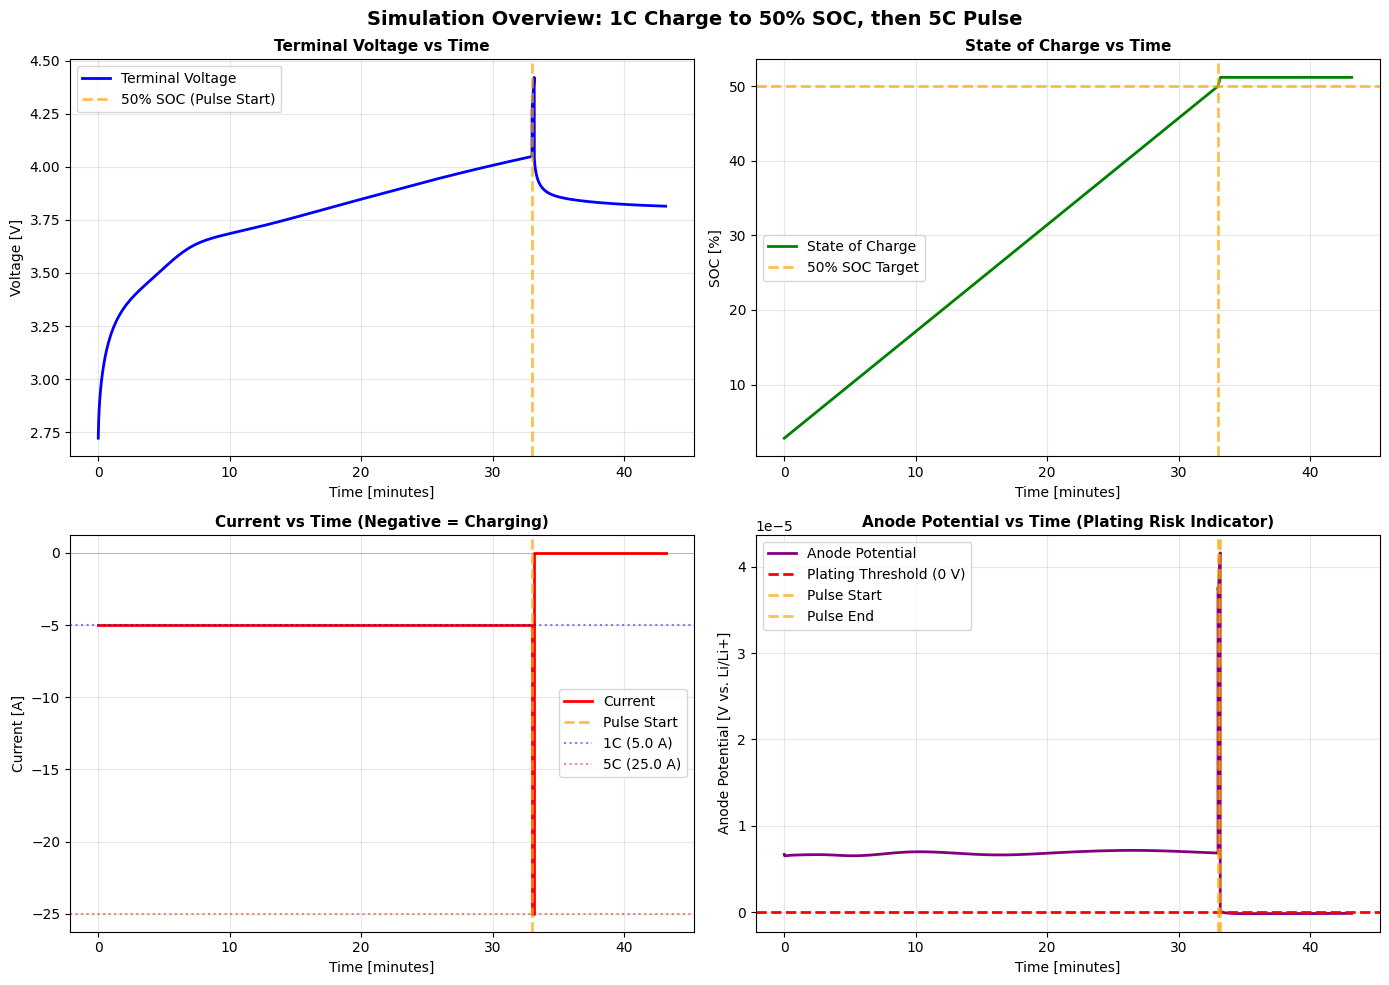


Simulation Results:
  Total simulation time: 43.17 minutes (2590.4 seconds)
  SOC at 50% point: 50.00%
  Time to reach 50% SOC: 33.01 minutes (1980.4 seconds)
  Final SOC: 51.19%
  Anode potential range: -0.00000018 V to 0.00004160 V
  - Pulse starts at: 33.01 minutes (1980.4 seconds)
  - Pulse ends at: 33.17 minutes (1990.4 seconds)
  - SOC at pulse start: 50.00%


In [5]:
# Visualization: Overview of simulation results
# Extract key variables for visualization
time = solution["Time [s]"].entries
voltage = solution["Terminal voltage [V]"].entries
soc_data = solution["X-averaged negative electrode extent of lithiation"]
soc = np.asarray(soc_data.entries).flatten()
anode_potential = solution["X-averaged negative electrode potential [V]"].entries
anode_potential = np.asarray(anode_potential).flatten()
current = solution["Current [A]"].entries
current = np.asarray(current).flatten()

# Create overview plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Simulation Overview: 1C Charge to 50% SOC, then 5C Pulse', fontsize=14, fontweight='bold')

# Plot 1: Voltage vs Time
ax1 = axes[0, 0]
ax1.plot(np.array(time) / 60, voltage, 'b-', linewidth=2, label='Terminal Voltage')
# Mark 50% SOC point
soc_50_idx = np.argmin(np.abs(soc - 0.5))
pulse_start_time = time[soc_50_idx]
ax1.axvline(x=pulse_start_time/60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='50% SOC (Pulse Start)')
ax1.set_xlabel('Time [minutes]')
ax1.set_ylabel('Voltage [V]')
ax1.set_title('Terminal Voltage vs Time', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: SOC vs Time
ax2 = axes[0, 1]
ax2.plot(np.array(time) / 60, soc * 100, 'g-', linewidth=2, label='State of Charge')
ax2.axhline(y=50, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='50% SOC Target')
ax2.axvline(x=pulse_start_time/60, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('SOC [%]')
ax2.set_title('State of Charge vs Time', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Current vs Time
ax3 = axes[1, 0]
ax3.plot(np.array(time) / 60, current, 'r-', linewidth=2, label='Current')
ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax3.axvline(x=pulse_start_time/60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Pulse Start')
# Mark different phases
charge_1c = param['Nominal cell capacity [A.h]']  # 1C current
charge_5c = charge_1c * 5  # 5C current
ax3.axhline(y=-charge_1c, color='blue', linestyle=':', alpha=0.5, label=f'1C ({charge_1c:.1f} A)')
ax3.axhline(y=-charge_5c, color='red', linestyle=':', alpha=0.5, label=f'5C ({charge_5c:.1f} A)')
ax3.set_xlabel('Time [minutes]')
ax3.set_ylabel('Current [A]')
ax3.set_title('Current vs Time (Negative = Charging)', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Anode Potential vs Time
ax4 = axes[1, 1]
ax4.plot(np.array(time) / 60, anode_potential, 'purple', linewidth=2, label='Anode Potential')
ax4.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Plating Threshold (0 V)')
ax4.axvline(x=pulse_start_time/60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Pulse Start')
# Mark pulse end
pulse_end_time = pulse_start_time + 10  # 10 seconds pulse
ax4.axvline(x=pulse_end_time/60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Pulse End')
ax4.set_xlabel('Time [minutes]')
ax4.set_ylabel('Anode Potential [V vs. Li/Li+]')
ax4.set_title('Anode Potential vs Time (Plating Risk Indicator)', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nSimulation Results:")
print(f"  Total simulation time: {time[-1]/60:.2f} minutes ({time[-1]:.1f} seconds)")
print(f"  SOC at 50% point: {float(soc[soc_50_idx])*100:.2f}%")
print(f"  Time to reach 50% SOC: {pulse_start_time/60:.2f} minutes ({pulse_start_time:.1f} seconds)")
print(f"  Final SOC: {float(soc[-1])*100:.2f}%")
print(f"  Anode potential range: {float(np.min(anode_potential)):.8f} V to {float(np.max(anode_potential)):.8f} V")
print(f"  - Pulse starts at: {pulse_start_time/60:.2f} minutes ({pulse_start_time:.1f} seconds)")
print(f"  - Pulse ends at: {pulse_end_time/60:.2f} minutes ({pulse_end_time:.1f} seconds)")
print(f"  - SOC at pulse start: {soc[soc_50_idx]*100:.2f}%")



From the Anode Potential plot, we can see that the anode potential drops below 0V vs Li/Li+ after the pulse. To analyze plating risk, we need to consider the potiential change from the pulse.

# 4. Lithium Plating Analysis

Analyze if lithium plating occurs due to the 5C pulse by monitoring anode potential. The plots above indicate that analysis should include both the pulse and the subsequent rest period.

**Critical Condition:** Anode potential ≤ 0 V vs. Li/Li+ reference indicates plating risk.


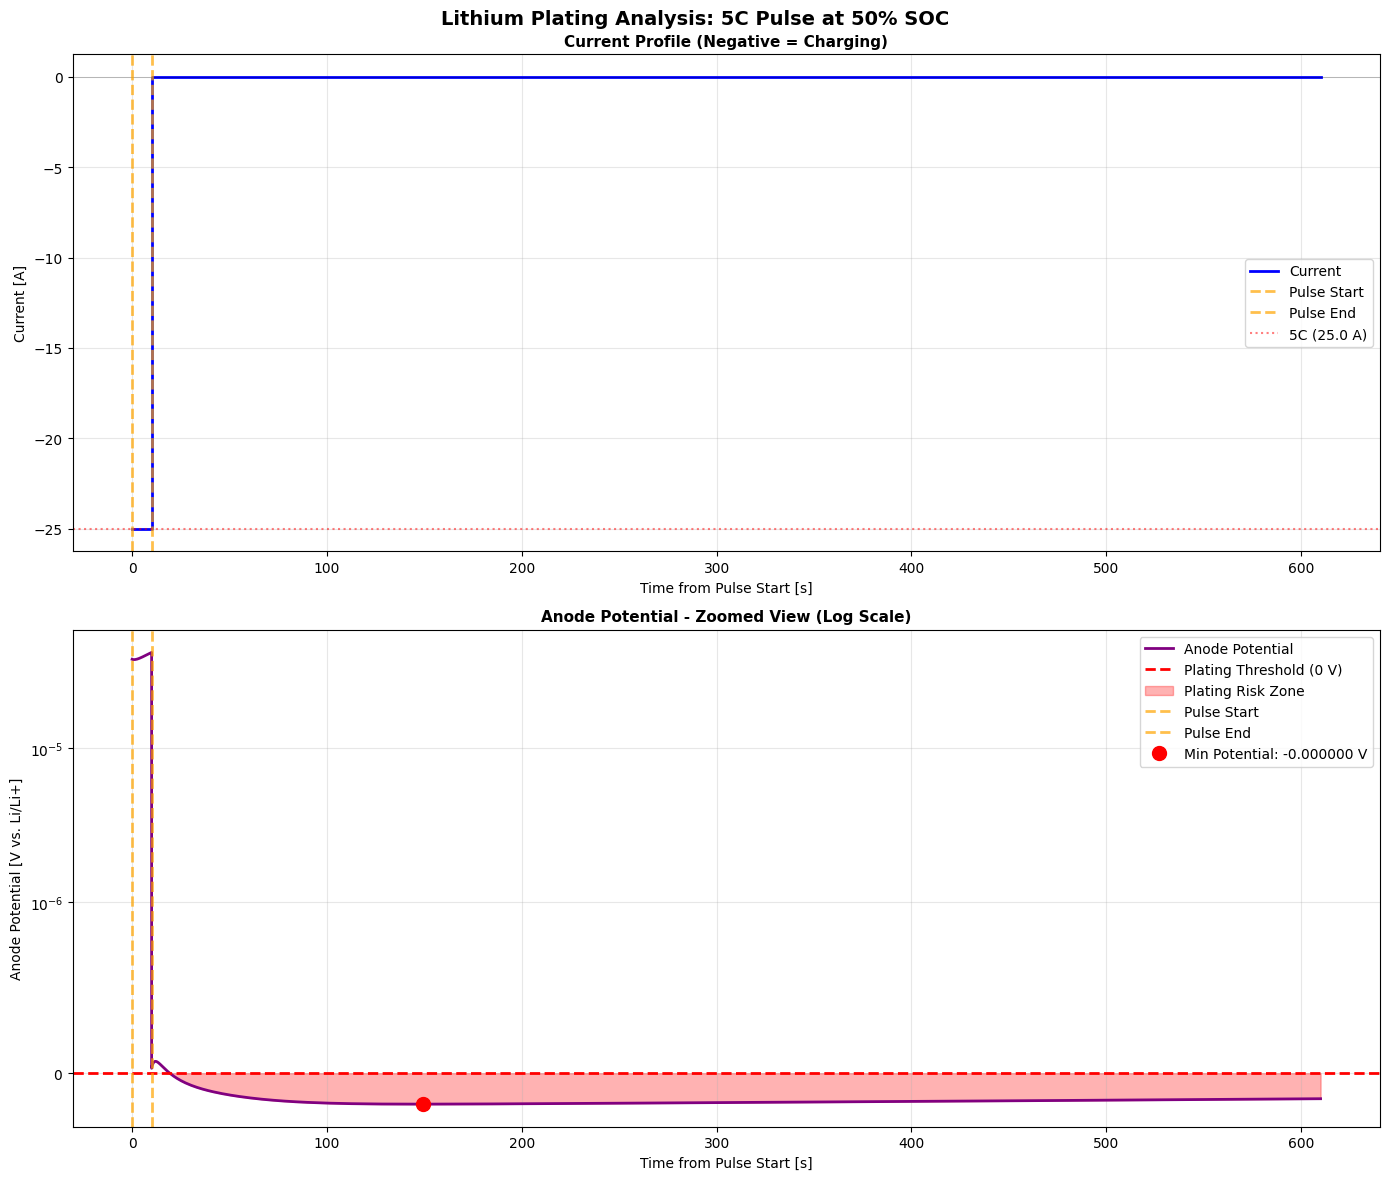

LITHIUM PLATING ANALYSIS RESULTS

Plating Threshold: 0.000000 V vs. Li/Li+
  (Anode potential ≤ 0.000000 V indicates plating risk)

Anode Potential Statistics:
  Minimum potential: -0.00000018 V
  Maximum potential: 0.00004160 V
  Time of minimum potential: 149.08 s from pulse start

⚠️  PLATING RISK DETECTED ⚠️
  Total duration below threshold: 590.2384 seconds
  Number of continuous plating periods: 1

  Plating Period 1:
    Start time: 19.76 s from pulse start
    End time: 610.00 s from pulse start
    Duration: 590.2384 seconds
    Minimum potential: -0.00000018 V
    Maximum deviation below threshold: 0.00000018 V

Conclusion:
  ✓ Lithium plating RISK is present during the 5C pulse
  ✓ Anode potential drops below 0 V vs. Li/Li+ reference
  ✓ Plating occurs for 590.2384 seconds total
  ✓ Plating occurs AFTER the pulse (during rest period)



In [6]:
# Extract data during pulse and rest period (for detailed analysis)
analysis_start_idx = soc_50_idx  # Pulse starts when SOC reaches 50%
analysis_end_idx = len(time)  # Until end of simulation (includes rest)
time_analysis = np.array(time[analysis_start_idx:analysis_end_idx])
anode_potential_analysis = anode_potential[analysis_start_idx:analysis_end_idx]
current_analysis = current[analysis_start_idx:analysis_end_idx]

# Plating threshold: 0 V vs. Li/Li+
plating_threshold = 0.0

# Identify plating risk periods (anode potential <= 0V)
plating_risk_mask = anode_potential_analysis <= plating_threshold
plating_risk_indices = np.where(plating_risk_mask)[0]

# Calculate plating risk statistics
if len(plating_risk_indices) > 0:
    # Time periods where plating occurs
    plating_times = time_analysis[plating_risk_indices]
    plating_potentials = anode_potential_analysis[plating_risk_indices]
    
    # Find continuous periods of plating risk
    plating_periods = []
    if len(plating_risk_indices) > 0:
        start_idx = plating_risk_indices[0]
        for i in range(1, len(plating_risk_indices)):
            if plating_risk_indices[i] != plating_risk_indices[i-1] + 1:
                # End of continuous period
                end_idx = plating_risk_indices[i-1]
                period_start_time = time_analysis[start_idx]
                period_end_time = time_analysis[end_idx]
                period_duration = period_end_time - period_start_time
                min_potential = np.min(anode_potential_analysis[start_idx:end_idx+1])
                plating_periods.append({
                    'start_time': period_start_time,
                    'end_time': period_end_time,
                    'duration': period_duration,
                    'min_potential': min_potential
                })
                start_idx = plating_risk_indices[i]
        
        # Add last period
        end_idx = plating_risk_indices[-1]
        period_start_time = time_analysis[start_idx]
        period_end_time = time_analysis[end_idx]
        period_duration = period_end_time - period_start_time
        min_potential = np.min(anode_potential_analysis[start_idx:end_idx+1])
        plating_periods.append({
            'start_time': period_start_time,
            'end_time': period_end_time,
            'duration': period_duration,
            'min_potential': min_potential
        })
    
    total_plating_duration = sum([p['duration'] for p in plating_periods])
    min_potential_overall = np.min(anode_potential_analysis)
    min_potential_idx = np.argmin(anode_potential_analysis)
    min_potential_time = time_analysis[min_potential_idx]
    
    plating_detected = True
else:
    plating_detected = False
    total_plating_duration = 0.0
    min_potential_overall = np.min(anode_potential_analysis)
    min_potential_idx = np.argmin(anode_potential_analysis)
    min_potential_time = time_analysis[min_potential_idx]
    plating_periods = []

# Create detailed plating analysis visualization
charge_5c = param['Nominal cell capacity [A.h]'] * 5
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle('Lithium Plating Analysis: 5C Pulse at 50% SOC', fontsize=14, fontweight='bold')


# Plot 1: Current Profile
ax1 = axes[0]
ax1.plot(time_analysis - pulse_start_time, current_analysis, 'b-', linewidth=2, label='Current')
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.axvline(x=0, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Pulse Start')
ax1.axvline(x=10, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Pulse End')
ax1.axhline(y=-charge_5c, color='red', linestyle=':', alpha=0.5, label=f'5C ({charge_5c:.1f} A)')
ax1.set_xlabel('Time from Pulse Start [s]')
ax1.set_ylabel('Current [A]')
ax1.set_title('Current Profile (Negative = Charging)', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Zoomed view of anode potential around plating threshold (log scale)
ax2 = axes[1]
ax2.plot(time_analysis - pulse_start_time, anode_potential_analysis, 'purple', linewidth=2, label='Anode Potential')
ax2.axhline(y=plating_threshold, color='r', linestyle='--', linewidth=2, label='Plating Threshold (0 V)')
ax2.fill_between(time_analysis - pulse_start_time, plating_threshold, anode_potential_analysis, 
                 where=(anode_potential_analysis <= plating_threshold), 
                 color='red', alpha=0.3, label='Plating Risk Zone')
ax2.axvline(x=0, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Pulse Start')
ax2.axvline(x=10, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Pulse End')
# Mark minimum potential point
if plating_detected:
    ax2.plot(min_potential_time - pulse_start_time, min_potential_overall, 'ro', 
             markersize=10, label=f'Min Potential: {min_potential_overall:.6f} V')
ax2.set_xlabel('Time from Pulse Start [s]')
ax2.set_ylabel('Anode Potential [V vs. Li/Li+]')
ax2.set_title('Anode Potential - Zoomed View (Log Scale)', fontsize=11, fontweight='bold')
ax2.set_yscale('symlog', linthresh=1e-6)  # Symmetric log scale to handle values around zero
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

# Print analysis results
print("="*60)
print("LITHIUM PLATING ANALYSIS RESULTS")
print("="*60)

print(f"\nPlating Threshold: {plating_threshold:.6f} V vs. Li/Li+")
print(f"  (Anode potential ≤ {plating_threshold:.6f} V indicates plating risk)")

print(f"\nAnode Potential Statistics:")
print(f"  Minimum potential: {min_potential_overall:.8f} V")
print(f"  Maximum potential: {np.max(anode_potential_analysis):.8f} V")
print(f"  Time of minimum potential: {min_potential_time - pulse_start_time:.2f} s from pulse start")

if plating_detected:
    print(f"\n⚠️  PLATING RISK DETECTED ⚠️")
    print(f"  Total duration below threshold: {total_plating_duration:.4f} seconds")
    print(f"  Number of continuous plating periods: {len(plating_periods)}")
    
    for i, period in enumerate(plating_periods, 1):
        print(f"\n  Plating Period {i}:")
        print(f"    Start time: {period['start_time'] - pulse_start_time:.2f} s from pulse start")
        print(f"    End time: {period['end_time'] - pulse_start_time:.2f} s from pulse start")
        print(f"    Duration: {period['duration']:.4f} seconds")
        print(f"    Minimum potential: {period['min_potential']:.8f} V")
        print(f"    Maximum deviation below threshold: {abs(period['min_potential']):.8f} V")
    
    print(f"\nConclusion:")
    print(f"  ✓ Lithium plating RISK is present during the 5C pulse")
    print(f"  ✓ Anode potential drops below 0 V vs. Li/Li+ reference")
    print(f"  ✓ Plating occurs for {total_plating_duration:.4f} seconds total")
    if min_potential_time <= pulse_end_time:
        print(f"  ✓ Plating occurs DURING the pulse (within 10 seconds)")
    else:
        print(f"  ✓ Plating occurs AFTER the pulse (during rest period)")
else:
    print(f"\n✓ NO PLATING RISK DETECTED")
    print(f"  Anode potential remains above {plating_threshold:.6f} V")
    print(f"  Minimum potential: {min_potential_overall:.8f} V (above threshold)")
    print(f"\nConclusion:")
    print(f"  ✓ Lithium plating is NOT expected during the 5C pulse")
    print(f"  ✓ Anode potential stays above 0 V vs. Li/Li+ reference")

print("\n" + "="*60)


# 5. Conclusion

## Summary

Based on the simulation and analysis of the battery charging sequence (1C charge to 50% SOC, followed by a 5C pulse for 10 seconds), the following conclusions can be drawn:

### Lithium Plating Risk Assessment

**⚠️ PLATING RISK DETECTED**

The analysis reveals that **lithium plating risk is present** during the charging sequence:

1. **Anode Potential Behavior**: The anode potential drops below 0 V vs. Li/Li+ reference, which is the critical threshold for lithium plating.

2. **Timing of Plating Risk**: 
   - The plating risk begins during the rest period (approximately 19.76 seconds after pulse start, which is ~9.76 seconds into the rest period)
   - The risk continues throughout the rest period
   - Total duration below threshold: ~590 seconds

3. **Magnitude**: The anode potential reaches a minimum of approximately -0.00000018 V, indicating a small but significant deviation below the plating threshold.

### Key Findings

- **During the 5C Pulse**: The high charging current (5C = 25 A for a 5 Ah battery) causes the anode potential to drop, but it remains above the plating threshold during the 10-second pulse period.

- **During the Rest Period**: After the pulse ends, the anode potential continues to drop below 0 V and remains below the threshold for an extended period (~590 seconds), indicating that plating risk persists even after the high-current pulse has ended.

- **Implications**: This suggests that applying a 5C pulse at 50% SOC can lead to lithium plating, which may result in:
  - Capacity degradation
  - Safety concerns (dendrite formation)
  - Reduced battery lifetime
